In [44]:
%matplotlib inline

import os
import json
import sys
import copy

from pprint import pprint

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

import cost_model

# the folder containing all exports
EXPORT_DIR = "./saved_designs"
FEATURE_NAMES = []

def load_design(design_dir):
    """the directory containing exported designs"""

    design = {}
    # load saved designs and trashed designs
    with open(os.path.join(design_dir, "saved.json")) as f:
        design["saved"] = json.load(f)["saved"]
    with open(os.path.join(design_dir, "trashed.json")) as f:
        design["trashed"] = json.load(f)["trashed"]
    design["dirname"] = design_dir
    return design


def load_dataset(export_dir):
    # load all designs from the export dir
    # iterate over all exported deisngs
    dataset = []
    dirs = os.listdir(export_dir)
    np.random.shuffle(dirs)
    for dirname in dirs:
        
        design_dir = os.path.join(export_dir, dirname)
        if not os.path.isdir(design_dir):
            continue
        designs = load_design(design_dir)

        saved = designs["saved"]
        trashed = designs["trashed"]
        
        if saved == [] or trashed == []:
            continue
        
        saved_features = [get_feature(s) for s in saved]
        trashed_features = [get_feature(t) for t in trashed]
        
        for fs in saved_features:
            for ts in trashed_features:
                if np.random.randint(2) == 1:
                    dataset.append((fs - ts, 1, dirname))
                else:
                    dataset.append((ts - fs, -1, dirname))

    return dataset


def get_feature(design):
    # process layout trees
    layout_tree = design["elements"]
    layout_tree = copy.deepcopy(layout_tree)
    cost_model.process_element_tree(layout_tree)

    # compute features
    screen_features = cost_model.extract_layout_features(layout_tree)

    return np.array([screen_features[key] for key in sorted(screen_features)])


dataset = load_dataset(EXPORT_DIR)
print(len(dataset))

# ds_index = list(range(len(dataset)))
# np.random.shuffle(ds_index)
# train_index, dev_index, test_index = np.split(ds_index, [10, 13])


1175


[[-0.75750675  0.90190642]]
0.0
# train acc: 0.603030303030303
# dev acc: 0.6063348416289592
# test acc: 0.6020408163265306
[['avg_alignment_score', 'avg_element_height', 'avg_element_width', 'density', 'imbalance', 'top_level_align_score', 'top_level_balance_score', 'top_level_overlapping_area']]
[[-1.05111677 -1.96250352 -2.06888861 -1.37314986 -0.38605967  0.76130918
   0.71020837  0.        ]]
0.0
# train acc: 0.6757575757575758
# dev acc: 0.6380090497737556
# test acc: 0.6836734693877551


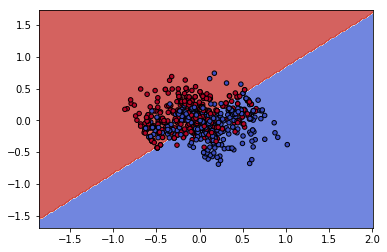

In [48]:
from sklearn.decomposition import PCA

Xs = [p[0] for p in dataset]
ys = [p[1] for p in dataset]
Zs = [p[2] for p in dataset]

#print(Zs)

pca = PCA(n_components=2)
Xs_2d = pca.fit_transform(Xs)

weights = {
    'top_level_align_score': None, 
    'top_level_balance_score': None, 
    'top_level_overlapping_area': None, 
    'avg_element_width': None, 
    'avg_element_height': None, 
    'avg_alignment_score': None, 
    'density': None, 
    'imbalance': None
}

def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

from sklearn.model_selection import train_test_split, KFold
from sklearn import svm

def train(Xs, ys, plot=True):

    X_train_dev, X_test, y_train_dev, y_test = train_test_split(Xs, ys, test_size=0.25, random_state=42)
    X_train, X_dev, y_train, y_dev = train_test_split(X_train_dev, y_train_dev, test_size=0.25, random_state=33)

    clf = svm.LinearSVC(fit_intercept=False, penalty="l1", dual=False)
    clf.fit(X_train, y_train)

    print(clf.coef_)
    print(clf.intercept_)
    
    pred = clf.predict(X_train)
    train_acc = np.sum(pred == y_train) / len(pred)
    print("# train acc: {}".format(train_acc))
    
    pred = clf.predict(X_dev)
    dev_acc = np.sum(pred == y_dev) / len(pred)
    print("# dev acc: {}".format(dev_acc))
    
    pred = clf.predict(X_test)
    test_acc = np.sum(pred == y_test) / len(pred)
    print("# test acc: {}".format(test_acc))
    
    if plot:
        fig, ax = plt.subplots()

        X0, X1 = Xs[:, 0], Xs[:, 1]
        xx, yy = make_meshgrid(X0, X1)
        plot_contours(ax, clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
        ax.scatter(X0, X1, c=ys, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())

train(Xs_2d, ys)

print([sorted(weights.keys())])
train(Xs, ys, plot=False)